In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


## Get data

In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.0)
sns.set(style='darkgrid')

import missingno as msno
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

In [3]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/train.csv", parse_dates=["date"])
test = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/test.csv", parse_dates=["date"])

In [4]:
train.shape

(26298, 6)

In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [6]:
train = train.drop("row_id", axis=1)
train.head()

,date,country,store,product,num_sold
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [7]:
test.shape

(6570, 5)

In [8]:
test = test.drop("row_id", axis=1)
test.head()

,date,country,store,product
0,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.0+ MB


In [10]:
train.store.unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

In [11]:
train.country.unique()

array(['Finland', 'Norway', 'Sweden'], dtype=object)

In [12]:
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NAN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum()/train[col].shape[0]))
    print(msg)

column:       date	 Percent of NAN value: 0.00%
column:    country	 Percent of NAN value: 0.00%
column:      store	 Percent of NAN value: 0.00%
column:    product	 Percent of NAN value: 0.00%
column:   num_sold	 Percent of NAN value: 0.00%


In [13]:
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["day"] = train["date"].dt.day
train["season"] = np.where(train["month"].isin([3,4,5]), "spring", 
                    np.where(train["month"].isin([6,7,8]), "summer", 
                    np.where(train["month"].isin([9,10,11]), "autumn", 
                    np.where(train["month"].isin([12,1,2]), "winter", "none"))))
train = train.drop("date", axis=1)
train.shape

(26298, 8)

In [14]:
test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month
test["day"] = test["date"].dt.day
test["season"] = np.where(test["month"].isin([3,4,5]), "spring", 
                    np.where(test["month"].isin([6,7,8]), "summer", 
                    np.where(test["month"].isin([9,10,11]), "autumn", 
                    np.where(test["month"].isin([12,1,2]), "winter", "none"))))
test = test.drop("date", axis=1)
test.shape

(6570, 7)

(array([1.4779e+04, 7.4220e+03, 2.7990e+03, 9.1100e+02, 2.6700e+02,
        8.3000e+01, 2.3000e+01, 1.0000e+01, 1.0000e+00, 3.0000e+00]),
 array([  70. ,  351.4,  632.8,  914.2, 1195.6, 1477. , 1758.4, 2039.8,
        2321.2, 2602.6, 2884. ]),
 <BarContainer object of 10 artists>)

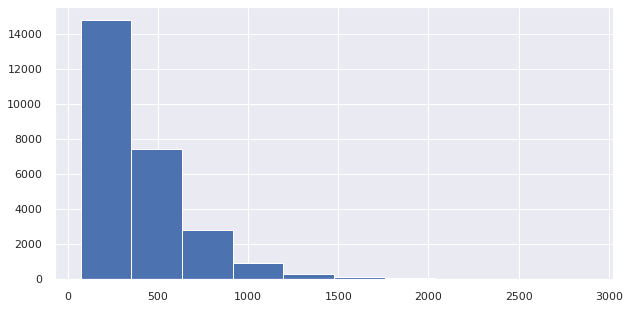

In [15]:
plt.figure(figsize=(10,5)) 
plt.hist(train['num_sold'])

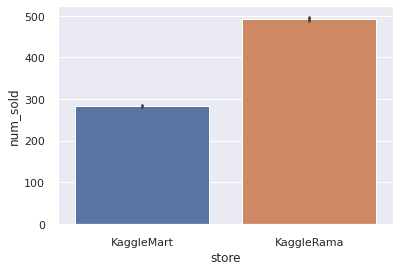

In [16]:
ax = sns.barplot(x='store', y='num_sold', data=train)

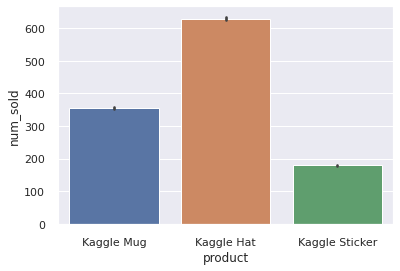

In [17]:
ax = sns.barplot(x='product', y='num_sold', data=train)

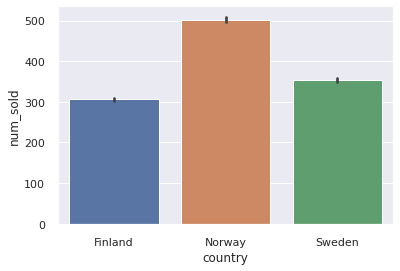

In [18]:
ax = sns.barplot(x='country', y='num_sold', data=train)

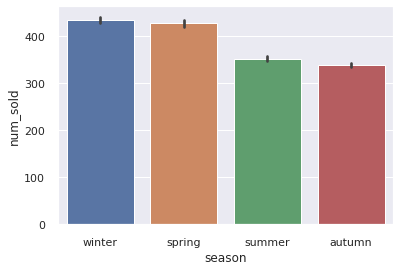

In [19]:
ax = sns.barplot(x='season', y='num_sold', data=train)

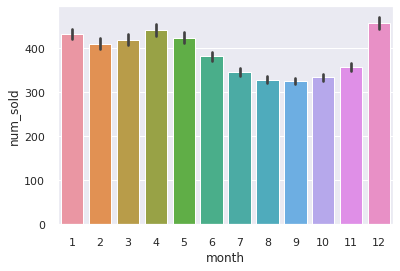

In [20]:
ax = sns.barplot(x='month', y='num_sold', data=train)

In [21]:
cleanup_nums = {"country": {"Finland": 1, "Norway": 2, "Sweden":3},
                "store":   {"KaggleMart": 1, "KaggleRama": 2},
                "product": {"Kaggle Hat": 1, "Kaggle Mug": 2, "Kaggle Sticker": 3},
                "season" : {"spring":1, "summer":2, "autumn":3, "winter":4, "none":5}
               }

In [22]:
train = train.replace(cleanup_nums)
train.head()

,country,store,product,num_sold,year,month,day,season
0,1,1,2,329,2015,1,1,4
1,1,1,1,520,2015,1,1,4
2,1,1,3,146,2015,1,1,4
3,1,2,2,572,2015,1,1,4
4,1,2,1,911,2015,1,1,4


In [23]:
test = test.replace(cleanup_nums)
test.head()

,country,store,product,year,month,day,season
0,1,1,2,2019,1,1,4
1,1,1,1,2019,1,1,4
2,1,1,3,2019,1,1,4
3,1,2,2,2019,1,1,4
4,1,2,1,2019,1,1,4


In [24]:
# continous features vs categorical features
categorical_feature_names = ["country", "store", "product", "season"]
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   country   26298 non-null  category
 1   store     26298 non-null  category
 2   product   26298 non-null  category
 3   num_sold  26298 non-null  int64   
 4   year      26298 non-null  int64   
 5   month     26298 non-null  int64   
 6   day       26298 non-null  int64   
 7   season    26298 non-null  category
dtypes: category(4), int64(4)
memory usage: 925.2 KB


In [26]:
#one hot encoding
train = pd.get_dummies(train, columns=['country'], prefix='country')
train = pd.get_dummies(train, columns=['store'], prefix='store')
train = pd.get_dummies(train, columns=['product'], prefix='product')
train = pd.get_dummies(train, columns=['season'], prefix='season')

In [27]:
test = pd.get_dummies(test, columns=['country'], prefix='country')
test = pd.get_dummies(test, columns=['store'], prefix='store')
test = pd.get_dummies(test, columns=['product'], prefix='product')
test = pd.get_dummies(test, columns=['season'], prefix='season')

In [28]:
train.head()

,num_sold,year,month,day,country_1,country_2,country_3,store_1,store_2,product_1,product_2,product_3,season_1,season_2,season_3,season_4
0,329,2015,1,1,1,0,0,1,0,0,1,0,0,0,0,1
1,520,2015,1,1,1,0,0,1,0,1,0,0,0,0,0,1
2,146,2015,1,1,1,0,0,1,0,0,0,1,0,0,0,1
3,572,2015,1,1,1,0,0,0,1,0,1,0,0,0,0,1
4,911,2015,1,1,1,0,0,0,1,1,0,0,0,0,0,1


In [29]:
X_train = train
X_train = X_train.drop("num_sold", axis=1)

print(X_train.shape)
X_train.head()

(26298, 15)


,year,month,day,country_1,country_2,country_3,store_1,store_2,product_1,product_2,product_3,season_1,season_2,season_3,season_4
0,2015,1,1,1,0,0,1,0,0,1,0,0,0,0,1
1,2015,1,1,1,0,0,1,0,1,0,0,0,0,0,1
2,2015,1,1,1,0,0,1,0,0,0,1,0,0,0,1
3,2015,1,1,1,0,0,0,1,0,1,0,0,0,0,1
4,2015,1,1,1,0,0,0,1,1,0,0,0,0,0,1


In [30]:
X_test = test
print(X_test.shape)
X_test.head()

(6570, 15)


,year,month,day,country_1,country_2,country_3,store_1,store_2,product_1,product_2,product_3,season_1,season_2,season_3,season_4
0,2019,1,1,1,0,0,1,0,0,1,0,0,0,0,1
1,2019,1,1,1,0,0,1,0,1,0,0,0,0,0,1
2,2019,1,1,1,0,0,1,0,0,0,1,0,0,0,1
3,2019,1,1,1,0,0,0,1,0,1,0,0,0,0,1
4,2019,1,1,1,0,0,0,1,1,0,0,0,0,0,1


In [31]:
label_name = "num_sold"
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(26298,)


0    329
1    520
2    146
3    572
4    911
Name: num_sold, dtype: int64

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   year       26298 non-null  int64
 1   month      26298 non-null  int64
 2   day        26298 non-null  int64
 3   country_1  26298 non-null  uint8
 4   country_2  26298 non-null  uint8
 5   country_3  26298 non-null  uint8
 6   store_1    26298 non-null  uint8
 7   store_2    26298 non-null  uint8
 8   product_1  26298 non-null  uint8
 9   product_2  26298 non-null  uint8
 10  product_3  26298 non-null  uint8
 11  season_1   26298 non-null  uint8
 12  season_2   26298 non-null  uint8
 13  season_3   26298 non-null  uint8
 14  season_4   26298 non-null  uint8
dtypes: int64(3), uint8(12)
memory usage: 924.7 KB


## Score

In [33]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

smape_scorer = make_scorer(smape)
smape_scorer

make_scorer(smape)

In [34]:
# smape test
a = {'0':100, '1':200, '2':300, '3':400, '4':500}
aa = pd.Series(data=a, index=['0', '1', '2', '3', '4'])

b = {'0':100, '1':200, '2':300, '3':600, '4':800}
bb = pd.Series(data=b, index=['0', '1', '2', '3', '4'])
    
smape(aa, bb) # 100% 0

17.230769230769234

In [35]:
# KFold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## model

### 0. best

In [36]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators=100, 
                             n_jobs=-1, 
                             random_state=0)

%time
score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=smape_scorer)
score = score.mean()
print("score = {0:.5f}".format(score))

%time
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
score = 10.11795
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
(6570,)


array([ 392.76,  541.44,  159.03,  670.74,  976.95,  283.42,  604.33,
        881.08,  260.29, 1074.4 ])

### 1. linear regression

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [38]:
lModel = LinearRegression()

y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

preds_l = lModel.predict(X_train)
print("SMAPE for Linear Regression:", smape(np.exp(y_train_log), np.exp(preds_l)))

SMAPE for Linear Regression: 13.829385285336812


### 2. ridge

In [39]:
ridge_m_ = Ridge()
ridge_params_ = {'max_iter':[3000], 'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
smape_scorer = metrics.make_scorer(smape, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_, 
                           ridge_params_,
                           scoring = smape_scorer,
                           cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X_train, y_train_log)
preds_ridge = grid_ridge_m.predict(X_train)
print(grid_ridge_m.best_params_)
print('SMAPE for Ridge Regression:', smape(np.exp(y_train_log), np.exp(preds_ridge)))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 100, 'max_iter': 3000}
SMAPE for Ridge Regression: 13.832625320131655


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007301,0.000214,0.003672,0.000157,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-2.354834,-2.615204,-2.540135,-2.333357,-2.459109,-2.460528,0.107339,9
1,0.007500,0.000143,0.003753,0.000184,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-2.354837,-2.615213,-2.540135,-2.333338,-2.459093,-2.460523,0.107345,8
2,0.007520,0.000135,0.003590,0.000021,1,3000,"{'alpha': 1, 'max_iter': 3000}",-2.354874,-2.615300,-2.540136,-2.333151,-2.458936,-2.460479,0.107408,7
3,0.007513,0.000089,0.003707,0.000211,2,3000,"{'alpha': 2, 'max_iter': 3000}",-2.354915,-2.615396,-2.540137,-2.332943,-2.458761,-2.460431,0.107477,6
4,0.007270,0.000131,0.003529,0.000073,3,3000,"{'alpha': 3, 'max_iter': 3000}",-2.354958,-2.615494,-2.540139,-2.332738,-2.458588,-2.460383,0.107547,5


In [40]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["smape"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "smape"]].head()

,alpha,smape
0,0.01,2.460528
1,0.10,2.460523
2,1.00,2.460479
3,2.00,2.460431
4,3.00,2.460383


In [41]:
df[["alpha", "smape"]].head()

,alpha,smape
0,0.01,2.460528
1,0.10,2.460523
2,1.00,2.460479
3,2.00,2.460431
4,3.00,2.460383


<AxesSubplot:xlabel='alpha', ylabel='smape'>

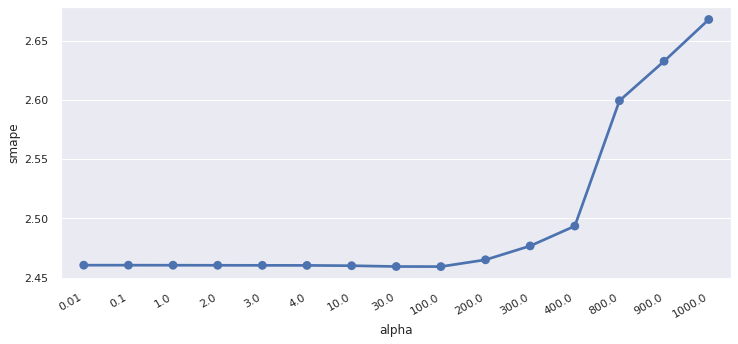

In [42]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="smape",ax=ax)

### 3. lasso

In [43]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=smape_scorer, cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train, y_train_log)
preds_lasso = grid_lasso_m.predict(X_train)
score = smape(np.exp(y_train_log), np.exp(preds_lasso))

print (grid_lasso_m.best_params_)
print ("SMAPE For Lasso Regression: ", score)

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["smape"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "smape"]].head()

{'alpha': 0.0025, 'max_iter': 3000}
SMAPE For Lasso Regression:  13.81368358477276


,alpha,smape
0,10.000000,9.338405
1,1.000000,9.338405
2,0.500000,9.338405
3,0.333333,9.338405
4,0.250000,9.338405


<AxesSubplot:xlabel='alpha', ylabel='smape'>

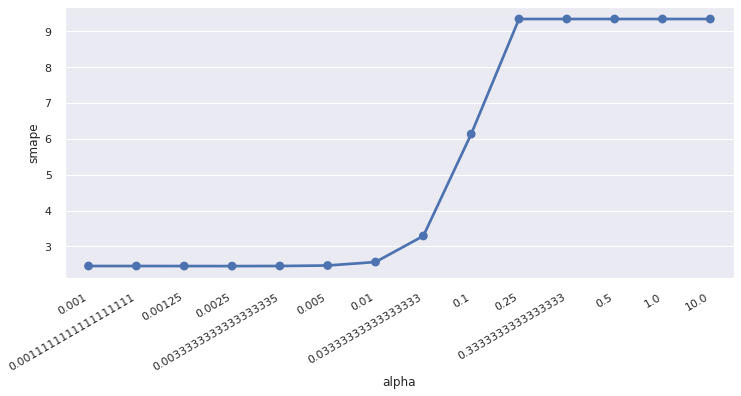

In [44]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="smape",ax=ax)

### 4. ensemble random forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds_rf = rfModel.predict(X_train)
score = smape(np.exp(y_train_log), np.exp(preds_rf))
print ("SMAPE For Random Forest: ",score)

SMAPE For Random Forest:  3.6196814682532197


### 5. gradient boost

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds_grad = gbm.predict(X_train)
score = smape(np.exp(y_train_log), np.exp(preds_grad))
print ("SMAPE For Gradient Boost: ", score)

SMAPE For Gradient Boost:  8.462882256024182


<AxesSubplot:ylabel='Density'>

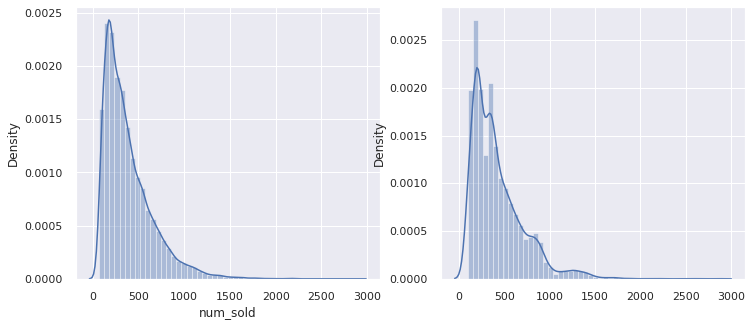

In [47]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

## Submit

In [48]:
submission = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv")
submission.head()

,row_id,num_sold
0,26298,100
1,26299,100
2,26300,100
3,26301,100
4,26302,100


In [49]:
submission["num_sold"] = np.round(predictions)
submission.head()

,row_id,num_sold
0,26298,393.0
1,26299,541.0
2,26300,159.0
3,26301,671.0
4,26302,977.0


In [50]:
submission.to_csv("./Score_{0:.5f}_submission.csv".format(score), index=False)